In [1]:

!pip install keras_vggface
!pip install keras_applications

     |████████████████████████████████| 51kB 5.8MB/s 


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image_dataset
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/dataset2.zip"

In [4]:
EPOCHS = 120
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 20

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.001
SGD_DECAY = 0.0001

Model Initialization


leave the weights of the feature extraction layers unchanged, only train on the weights of the fully connected and final classification layer

In [5]:
def svm_loss(layer):
    weights = layer.weights[0]
    weights_tf = tf.convert_to_tensor(weights)
    
    def categorical_hinge_loss(y_true, y_pred):
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1.0 - y_true) * y_pred, axis=-1)
        hinge_loss = K.mean(K.maximum(0.0, neg - pos + 1), axis=-1)
        regularization_loss = 0.5*(tf.reduce_sum(tf.square(weights_tf)))
        return regularization_loss + 0.4*hinge_loss
    
    return categorical_hinge_loss

In [6]:

vgg_model = VGGFace(model="vgg16", include_top=False, input_shape=(197,197,3),pooling="avg")

# print(vgg_model.summary())

last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)

for i in range(len(vgg_model.layers)):
    vgg_model.layers[i].trainable = False

# print(vgg_model.get_layer('pool5').trainable)

softmax_out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_model.input, softmax_out)
model.load_weights('/content/drive/MyDrive/model/VGG16/VGG16_sgd_-EPOCHS_120-DROPOUT_0.5-test_acc_0.683.h5')
svm_out = Dense(7, use_bias=False, activation='linear', name='svm')(x)
model2 = Model(model.input, svm_out)
print(model2.summary())

cp_filepath = '/content/drive/MyDrive/model/VGG16/VGG16_sgd_-EPOCHS_120-DROPOUT_0.5-test_acc_0.683.h5'
# optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optim = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode="max", factor=0.5,
                              patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model2.compile(optimizer=optim, loss=svm_loss(model2.get_layer('svm')), metrics=['accuracy'])

58916864/58909280 [==============================] - 2s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 197, 197, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98, 98, 128)       147584    
_______________________________________________________

load in preprocessed data

In [7]:
def load_data(train_path, test_path):
    train_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(197, 197), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="training")
    val_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(197, 197), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="validation")
    test_data = image_dataset.image_dataset_from_directory(
            test_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(197, 197), 
            shuffle=True)
    return train_data, val_data, test_data


train_data, valid_data, test_data = load_data("/content/drive/MyDrive/dataset2/train", "/content/drive/MyDrive/dataset2/test")

Found 22035 files belonging to 7 classes.
Using 17628 files for training.
Found 22035 files belonging to 7 classes.
Using 4407 files for validation.
Found 5512 files belonging to 7 classes.


In [9]:
history = model2.fit(
    train_data,
    validation_data=valid_data,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[reduce_lr, checkpoint]
    )

Epoch 1/120
138/138 [==============================] - ETA: 0s - loss: 7.2838 - accuracy: 0.3906
Epoch 00001: val_accuracy improved from -inf to 0.53007, saving model to /content/drive/MyDrive/model/VGG16/VGG16_sgd_-EPOCHS_120-DROPOUT_0.5-test_acc_0.683.h5
138/138 [==============================] - 986s 7s/step - loss: 7.2838 - accuracy: 0.3906 - val_loss: 7.2510 - val_accuracy: 0.5301
Epoch 2/120
138/138 [==============================] - ETA: 0s - loss: 7.2782 - accuracy: 0.4045
Epoch 00002: val_accuracy improved from 0.53007 to 0.56819, saving model to /content/drive/MyDrive/model/VGG16/VGG16_sgd_-EPOCHS_120-DROPOUT_0.5-test_acc_0.683.h5
138/138 [==============================] - 74s 539ms/step - loss: 7.2782 - accuracy: 0.4045 - val_loss: 7.2486 - val_accuracy: 0.5682
Epoch 3/120
138/138 [==============================] - ETA: 0s - loss: 7.2703 - accuracy: 0.4281
Epoch 00003: val_accuracy improved from 0.56819 to 0.58543, saving model to /content/drive/MyDrive/model/VGG16/VGG16_sgd

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


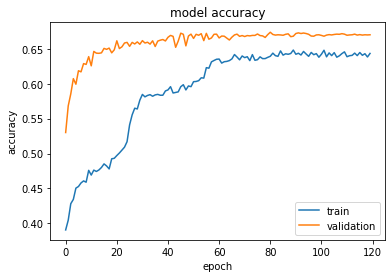

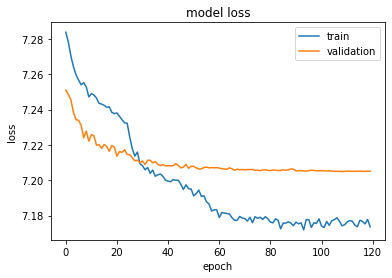

In [13]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig('/content/drive/MyDrive/model/VGG16/svm_VGG16_dense1024_sgd' + epoch_str + dropout_str + '-accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig('/content/drive/MyDrive/model/VGG16/svm_VGG16_dense1024_sgd' + epoch_str + dropout_str + '-loss.png')
plt.show()

In [10]:
print('\n# Evaluate on validation data')
results_val = model2.evaluate(valid_data, batch_size=BS)
print('validation loss, validation accuracy:', results_val)


# Evaluate on validation data
35/35 [==============================] - 12s 333ms/step - loss: 7.2051 - accuracy: 0.6701
validation loss, validation accuracy: [7.205143451690674, 0.6700703501701355]


In [11]:
print('\n# Evaluate on test data')
results_test = model2.evaluate(test_data, batch_size=BS)
print('test loss, test accuracy:', results_test)


# Evaluate on test data
44/44 [==============================] - 1998s 45s/step - loss: 7.2069 - accuracy: 0.6685
test loss, test accuracy: [7.206883907318115, 0.6685413718223572]


In [14]:
test_acc = '-test_acc_%.3f' % results_test[1]
model2.save('/content/drive/MyDrive/Colab Notebooks/SVM_VGG16_sgd_' + epoch_str + dropout_str + test_acc + '.h5')